1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?

CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?

Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?

기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

## STEP 0. 라이브러리 불러오기
---

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds

In [3]:
# 학습 전에는 항상 GPU 환경을 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## STEP 1. Data load
---
데이터셋을 불러와서 전처리 및 Augmentation을 적용하는 함수를 만들어 적용해줍니다.

- 데이터셋 : stanford_dogs  
    - 120개 견종, 총 20,580장의 이미지 
    - 12,000장은 train, 8,580장은 test

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train', 'test'],
    shuffle_files = True,
    with_info = True,
    as_supervised = True
)

In [5]:
ds_train

<_OptionsDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
#다운로드한 데이터 확인
ds_test

<_OptionsDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

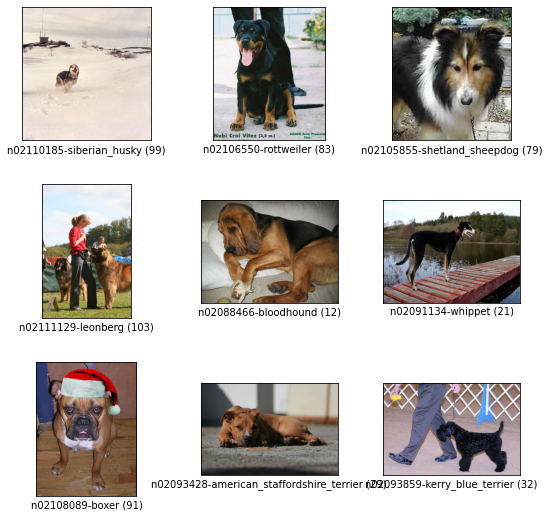

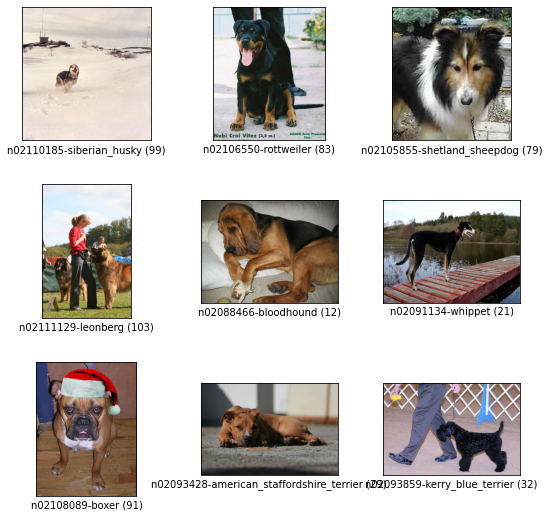

In [7]:
#다운로드한 데이터 확인
tfds.show_examples(ds_train, ds_info)

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [9]:
# num_classes 정의
num_classes = ds_info.features['label'].num_classes
num_classes

120

## STEP 2. Augmentation을 적용한 데이터셋 만들기
---
사용할 Augmentation은 
1. Augment (좌우반전, 밝기 조절)
2. Mix Up (일정비율로 픽셀값 합침)
3. Cut Out (랜덤하게 이미지를 잘라냄)
4. Cut Mix (랜덤하게 자른 이미지를 합침)

총 4가지이며, 아무것도 사용하지 않은 No Augmentation과 비교하여 Augmentation 영향을 살펴보려한다.

### 2-1 augment(좌우반전, 밝기 조절)
---
Augmentation은 실제 일어날 수 있을만한 상황에 맞춰 만들어 주는 것이 좋습니다.  
그래서 이번엔 좌우 반전과 밝기 조절만 하려고 합니다.

In [10]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224,224])
    
    return tf.cast(image, tf.float32) /255., label

In [11]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [12]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [13]:
# def onehot(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
#     imgs   = []
#     labels = []

#     for i in range(batch_size):
#         imgs.append(image[i])
#         labels.append(tf.one_hot(label[i], num_classes))

#     onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    
#     return onehot_imgs, labels

### 2.2 Mixup
---
- [Mixup 논문 : mixup:Beyond Empirical Risk Minimization](https://arxiv.org/pdf/1710.09412.pdf)
- mixup Augmentaion은 간단하게 이미지의 픽셀값을 랜덤 비율로 섞어서 이미지를 나타내고, 해당 label 또한 비율값에 맞춰 섞어주는 방법입니다. 
- 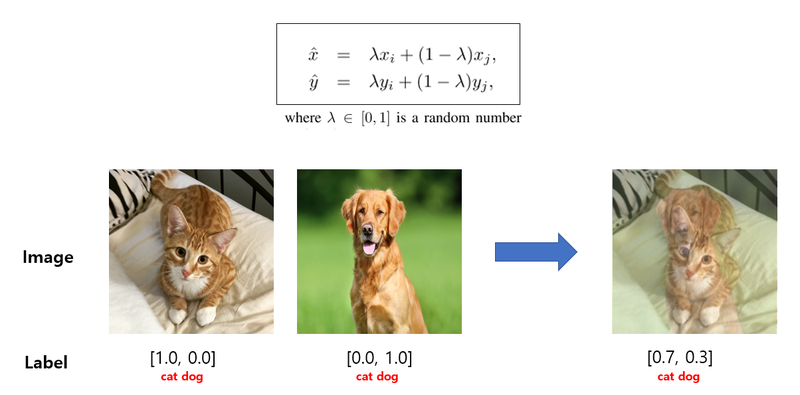
- 기본적으로 신경망은 훈련 데이터셋에 대한 평균 에러를 최소화함으로써 신경망을 최적화합니다. 이를 Empirical Risk Minimization(ERM) principle이라고 하는데, 우리가 현재 보유한 데이터의 empirical distribution(경험적 분포)을 통해서 risk(error)를 최소화하는 것입니다. 
- 이는 훈련 데이터에대해서 overfitting이 발생하는 단점이 있습니다. 따라서 ERM 기반의 학습의 신경망 일반화(Generalization)는 오직 훈련 데이터셋과 약간 다른 분포를 가진 test 데이터셋에서만 가능하게 됩니다.
- 그래서 새로운 방법인 **Vicinal Risk Minimization(VRM) principle**이 고안되었습니다. VRM 기반의 학습과 ERM 기반의 학습의 가장 큰 차이점은 훈련 데이터셋만 학습하는 것이 아니라 **훈련 데이터셋의 근방(vicinal) 분포도 함께 활용**한다는 것입니다
- 이 근방의 분포를 얻기위해 Data Augmentation을 하는 것이죠. 

- 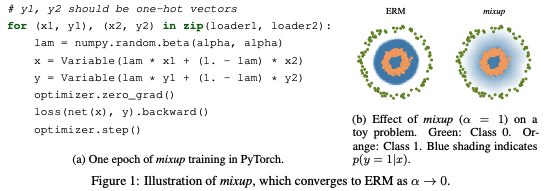
- 상기 오른쪽 이미지는 mixup을 사용한 학습결과와 사용하지않은 ERM 기반의 학습결과 입니다. 보면 decision boundary차이가 보이는데, ERM은 두 클래스간의 decision boundary가 명확하고 정확하게 분리가 됩니다. 하지만 mixup을 사용한 것은 decision boundary가 blurry한 것을 볼 수 있습니다. 이는 ERM에 비해 overfitting이 덜 발생한다는 것이며, mixup이 regularization의 역할도 한다고 볼 수 있습니다. 

- [참고 블로그](https://everyday-image-processing.tistory.com/145)

In [14]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [15]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('Mixup 함수 완료!')

Mixup 함수 완료!


### 2-3 CutOut
---
- [cutout논문 : Improved Regularization of Convolutional Neural Networks with Cutout](https://arxiv.org/pdf/1708.04552v2.pdf)
- 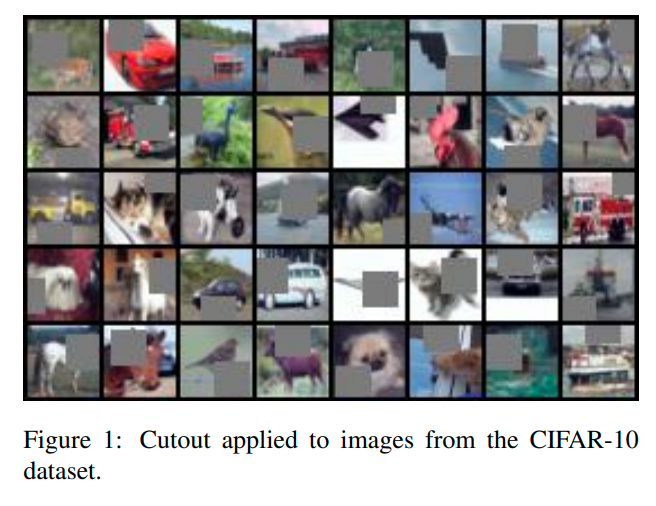
- cutout은 이미지에서 사각형으로 랜덤하게  잘라내서 0으로 마스킹하는 방법입니다(noise로 마스킹하면 Erasing). 이를 통해 Regularization과 Augmentation을 동시에 해결합니다. CNN의 overfitting 방지와 성능개선을 이뤄냅니다. 
- Cut Out은 object detecting시 객체의 일부분이 가려지는 object occlusion 문제를 개선하기 위해 고안되었습니다. 모델 학습시 잘려진 이미지를 넣어줌으로 test 데이터셋에서 object occlusion이 있어도 더 잘 판단할 수 있습니다. 
- 이전의 Out-of-Distribution Examples 논문에서는 스크래치나 점, 갈겨쓴 모양 등을 이미지에 합성시켜 이미지를 가리는 방식을 사용하였고, cutout은 0으로 채워넣는 방식입니다.
- 또한 0으로 채워넣는 것을 보면, 학습 단계에서 Network의 hidden unit activation을 일정 확률로 0으로 바꾸는 Dropout과 비슷합니다. 하지만 cutout은 중간에서 생성된 feature map이 아닌 input image 에서 0으로 채운다는 점에서 차이가 있습니다. 
- Dropout은 중간 단계의 layer의 feature map에서만 random하게 일부 영역을 지우고 각 feature map의 channel간 독립성이 존재하여 어떤 channel에서는 지워진 영역이 다른 channel에서는 지워지지 않게 되어 불일치성이 일부 존재하게 됩니다. 하지만 Cutout은 입력 단계에서 일부 영역을 지우고 그 결과 중간 단계의 layer에서도 같은 영역 주위를 지우는 것과 같은 효과를 볼 수 있으며 각 feature map의 channel간에도 상관 관계를 갖게 됩니다.

- [관련 블로그](https://hoya012.github.io/blog/Improved-Regularization-of-Convolutional-Neural-Networks-with-Cutout-Review/)

In [16]:
####### cut out 함수 ###########
def cutout(images, labels):
    cutout_imgs = tfa.image.random_cutout(images, (64, 64), constant_values = 1)
    cutout_imgs = tf.reshape(tf.stack(cutout_imgs), (16, 224, 224, 3))
    return cutout_imgs, labels

In [17]:
####### cut out 함수 ###########
# def cutout(images, label, cut_length = 64):
#     """
#     Perform cutout augmentation from images.
#     :param images: np.ndarray, shape: (N, H, W, C).
#     :param cut_length: int, the length of cut(box).
#     :return: np.ndarray, shape: (N, h, w, C).
#     tf.Tensor.get_shape()
#     """

#     H, W, C = tf.Tensor.get_shape(images).shape[1:4]
#     augmented_images = []
#     for image in images:    # image.shape: (H, W, C)
#         image_mean = image.mean(keepdims=True)
#         image -= image_mean

#         mask = np.ones((H, W, C), np.float32)

#         y = np.random.randint(H)
#         x = np.random.randint(W)
#         length = cut_length

#         y1 = np.clip(y - (length // 2), 0, H)
#         y2 = np.clip(y + (length // 2), 0, H)
#         x1 = np.clip(x - (length // 2), 0, W)
#         x2 = np.clip(x + (length // 2), 0, W)

#         mask[y1: y2, x1: x2] = 0.
#         image = image * mask

#         image += image_mean
#         augmented_images.append(image)

#     return np.stack(augmented_images), label    # shape: (N, h, w, C)

### 2-4. Cutmix Augmentation
---
- [Cutmix 논문: CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)
- [캐글 예시 : Chris Deotte's CutMix and MixUp on GPU/TPU](https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook)

- CutMix는 말그대로 데이터를 자르고 섞는 방법입니다.  Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식입니다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다.   
- CutMix는 모델이 이미지의 객체 특징에 집중하지 않고, 덜 구분되는 부분 및 이미지의 전체적인 특징을 보고 학습하도록 하여 일반화와 localization 성능을 높이는 방법입니다.  
- train set과 test set의 분포가 다른 경우를 의미하는 OOD(out of distribution)와 이미지가 가려진 sample, adversarial sample에서의 robustness도 좋은 성능을 나타냅니다.
- 아래에서 진행해볼 NO augmentation, Mixup, Cutout, Cutmix의 비료 표입니다. classification, Localization, Detection 3가지 task에서 성능강화가 일어난 것을 보여주고 있습니다. 
- 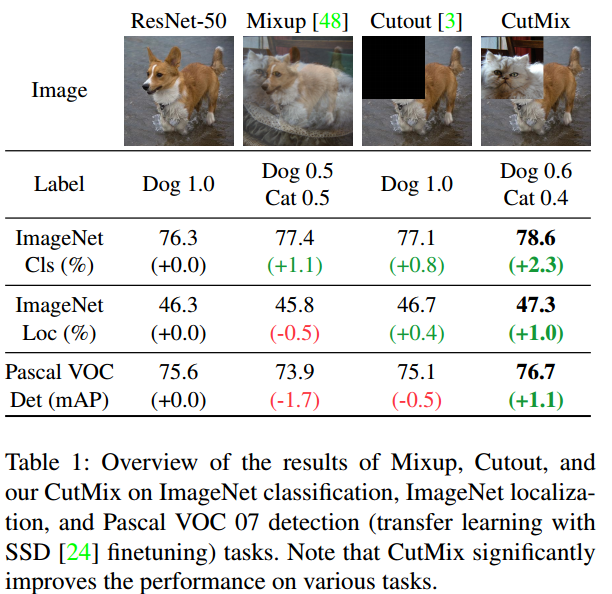

In [18]:
########## Boundering Box 함수 ##########
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    #get boundering box 
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    
    # get width, height of box 
    # 이 w, h를 통해 box size결정 -> 데이터 결합비율 결정됨
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bounding box
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [19]:
# mix two images
def mix_2_image(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[0]
    image_size_y = image_b.shape[1]
    # image_b의 왼쪽 바깥 영역
    middle_left = image_a[y_min:y_max, 0:x_min, :] 
    # image_b의 안쪽 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]
    # image_b의 오른쪽 바깥 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]
    
    middle = tf.concat([middle_left, middle_center, middle_right], axis = 1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    
    mixed_image = tf.concat([top, middle, bottom], axis = 0)
    
    return mixed_image

In [20]:
######### 라벨 Mix ###########
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    # image_size_x = image_a.shape[1]
    image_size_x = 224
    # image_size_y = image_a.shape[0]
    image_size_y = 224
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_label

In [21]:
############ 전체 Cut Mix 함수 ##############
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, 
num_classes=120):
    
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        
        mixed_imgs.append(mix_2_image(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))
    
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

print('Cut Mix 함수 완룡!')

Cut Mix 함수 완룡!


### 2-5 데이터셋에 각각 적용 하기

In [22]:
ds_train = ds_train.map(normalize_and_resize_img, num_parallel_calls = 2)
ds_test = ds_test.map(normalize_and_resize_img, num_parallel_calls = 2)
ds_test = ds_test.map(onehot, num_parallel_calls=2)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size = 16)

In [23]:
########## 데이터 셋에 적용 함수 ##########
def apply_normalize_on_dataset(ds, 
                               batch_size = 16,
                               is_test = False,
                               with_aug = False,
                               with_mixup = False,
                               with_cutout = False,
                               with_cutmix = False
                               ):
    ds = ds.batch(batch_size)
    
    # 1. augument
    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls = 2)

    # 2. mixup    
    if not is_test and with_mixup:
        ds = ds.map(mixup, num_parallel_calls = 2)

    # 3. cutout
    if not is_test and with_cutout:
        ds = ds.map(cutout, num_parallel_calls = 2)

    # 4. cutmix 
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls = 2)

    # 5. no augmentation
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)   

    if not (with_mixup or with_cutmix):
        ds = ds.map(onehot, num_parallel_calls=2)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

이제 각 augmentation을 적용한 dataset을 생성해 줍니다.

In [25]:
# 1. augument
ds_train_aug = apply_normalize_on_dataset(ds_train,
                                         with_aug = True)
# # 2. mixup 
ds_train_mixup = apply_normalize_on_dataset(ds_train,
                                         with_mixup = True)
# # 3. cutout
ds_train_cutout = apply_normalize_on_dataset(ds_train,
                                         with_cutout = True)
# # 4. cutmix 
ds_train_cutmix = apply_normalize_on_dataset(ds_train,
                                         with_cutmix = True)
# # # 5. no augmentation
ds_train_no_aug = apply_normalize_on_dataset(ds_train, 
                                             with_aug=False)

print('데이터셋 준비 완료')

데이터셋 준비 완료


## STEP 3. 모델 제작 및 훈련하기
---
- 모델은 pretrain된 ResNet-50을 사용하며 각 augmentation 상황에 맞춰 모델을 따로 생성하여 훈련시켜줍니다. 

1.  No Augmentation
2. 기본 Augmentation
3. 기본 + CutMix 적용
4. 기본 + Cutout 적용
5. 기본 + Mixup 적용


### 3-1. No Augmentation

In [26]:
######### 1. No Augmentation ##########
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('1. No Augmentation ResNet')

1. No Augmentation ResNet


In [27]:
EPOCH = 20 

resnet50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # no augmentation 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 103s 122ms/step - loss: 2.2378 - accuracy: 0.4391 - val_loss: 3.4904 - val_accuracy: 0.1851
Epoch 2/20
750/750 [==============================] - 90s 121ms/step - loss: 0.6724 - accuracy: 0.8227 - val_loss: 1.0809 - val_accuracy: 0.6868
Epoch 3/20
750/750 [==============================] - 90s 121ms/step - loss: 0.1839 - accuracy: 0.9659 - val_loss: 0.9199 - val_accuracy: 0.7267
Epoch 4/20
750/750 [==============================] - 90s 121ms/step - loss: 0.0479 - accuracy: 0.9968 - val_loss: 0.8948 - val_accuracy: 0.7396
Epoch 5/20
750/750 [==============================] - 90s 121ms/step - loss: 0.0229 - accuracy: 0.9993 - val_loss: 0.9336 - val_accuracy: 0.7355
Epoch 6/20
750/750 [==============================] - 90s 121ms/step - loss: 0.0377 - accuracy: 0.9970 - val_loss: 0.9419 - val_accuracy: 0.7343
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0136 - accuracy: 0.9995 - val_loss: 0.9273 - val_a

### 3-2 Augment(좌우반전, 밝기조절)


In [29]:
######### 2. Normal Augumentation ##########
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('2. Normal Augumentation Resnet')

2. Normal Augumentation Resnet


In [30]:
EPOCH = 20 

aug_resnet50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, # augmentation 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 102s 126ms/step - loss: 2.2855 - accuracy: 0.4245 - val_loss: 2.7704 - val_accuracy: 0.3055
Epoch 2/20
750/750 [==============================] - 94s 125ms/step - loss: 0.9119 - accuracy: 0.7442 - val_loss: 1.1960 - val_accuracy: 0.6500
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 0.4518 - accuracy: 0.8806 - val_loss: 1.0316 - val_accuracy: 0.6953
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 0.2341 - accuracy: 0.9467 - val_loss: 0.9520 - val_accuracy: 0.7252
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 0.1212 - accuracy: 0.9782 - val_loss: 0.9895 - val_accuracy: 0.7255
Epoch 6/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0680 - accuracy: 0.9909 - val_loss: 1.0000 - val_accuracy: 0.7231
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0428 - accuracy: 0.9952 - val_loss: 0.9497 - val_a

### 3-3. Mixup

In [31]:
######### 3. MixUp Augumentation ##########
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('3. MixUp Augumentation')

3. MixUp Augumentation


In [ ]:
EPOCH = 20 

mixup_resnet50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # mixup augmentation 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 99s 123ms/step - loss: 3.7047 - accuracy: 0.2430 - val_loss: 3.7602 - val_accuracy: 0.1496
Epoch 2/20
750/750 [==============================] - 91s 122ms/step - loss: 2.8395 - accuracy: 0.4878 - val_loss: 1.4931 - val_accuracy: 0.5809
Epoch 3/20
750/750 [==============================] - 91s 122ms/step - loss: 2.5539 - accuracy: 0.5971 - val_loss: 1.4975 - val_accuracy: 0.5897
Epoch 4/20
750/750 [==============================] - 92s 122ms/step - loss: 2.3851 - accuracy: 0.6618 - val_loss: 1.3222 - val_accuracy: 0.6341
Epoch 5/20
750/750 [==============================] - 92s 122ms/step - loss: 2.2643 - accuracy: 0.6973 - val_loss: 1.2634 - val_accuracy: 0.6552
Epoch 6/20
750/750 [==============================] - 92s 122ms/step - loss: 2.1418 - accuracy: 0.7523 - val_loss: 1.4543 - val_accuracy: 0.6166
Epoch 7/20
750/750 [==============================] - 92s 122ms/step - loss: 2.0457 - accuracy: 0.7891 - val_loss: 1.1824 - val_ac

### 3-4 Cutout

In [ ]:
######### 4. Cutout Augumentation ##########
cutout_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('4. Cutout Augumentation')

In [ ]:
EPOCH = 20 

cutout_resnet50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_cutout_resnet50 = cutout_resnet50.fit(
    ds_train_cutout, # cutout augmentation 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

### 3-5 Cutmix

In [ ]:
######### 5. CutMix Augumentation ##########
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('3. MixUp Augumentation')

In [ ]:
EPOCH = 20 

cutmix_resnet50.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics = ['accuracy'])

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix augmentation 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)